In [ ]:
import pandas as pd
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
import os
import cv2
from tensorflow.keras import regularizers, Model
from keras.layers import Dense
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import Sequence
from keras.models import Model
from matplotlib import pyplot as plt
from tensorflow.keras.optimizers import Adam
import keras
import numpy as np
import random
import shutil

from tensorflow.keras.applications.mobilenet_v3 import preprocess_input

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Setup data splits in generators

In [ ]:
target = 224 # number of pixels. change this to 512 if you want to use the full image size. note: will slow computations

dataPath = '/kaggle/input/glaucoma-dataset-eyepacs-airogs-light-v2/eyepac-light-v2-512/'

batchSize = 8

trainDataGen = ImageDataGenerator(preprocessing_function=preprocess_input, horizontal_flip=True, vertical_flip=True, brightness_range=(0.9, 1.1))
trainGen = trainDataGen.flow_from_directory(batch_size = batchSize, shuffle=True,  class_mode="binary", target_size=(target, target), directory=dataPath + 'train', color_mode='rgb')

valDataGen = ImageDataGenerator(preprocessing_function=preprocess_input)
valGen = valDataGen.flow_from_directory(batch_size = 1, class_mode="binary", target_size=(target, target), directory=dataPath + 'validation', color_mode='rgb')

testDataGen = ImageDataGenerator(preprocessing_function=preprocess_input)
testGen = testDataGen.flow_from_directory(batch_size = 1, class_mode="binary", target_size=(target, target), directory=dataPath + 'test', color_mode='rgb')

Found 8000 images belonging to 2 classes.
Found 770 images belonging to 2 classes.
Found 770 images belonging to 2 classes.


## Create a MobileNetV3 instance

In [ ]:
def getModel(image_size, num_classes):
    model_input = keras.Input(shape=(image_size, image_size, 3))

    transfer = keras.applications.MobileNetV3Small(
        weights='imagenet',
        include_top=False,
        input_tensor=model_input,
        pooling='avg',
        alpha=0.75,
        dropout_rate=0.35,
        classifier_activation="softmax",
        include_preprocessing=False
    )

    model_output = Dense(1, activation='sigmoid') (transfer.output)

    return keras.Model(inputs=model_input, outputs=model_output)

model = getModel(image_size=target, num_classes=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.85, patience=2, min_lr=1e-5)
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath='val-best.h5',
    monitor='val_loss',
    mode='min',
    save_best_only=True)

2910456/2910456 [==============================] - 0s 0us/step


## Train the model

In [ ]:
model.compile(optimizer=Adam(1e-3), loss='binary_crossentropy', metrics=['binary_accuracy',keras.metrics.AUC(),keras.metrics.Precision(), keras.metrics.Recall()])

history = model.fit(trainGen, steps_per_epoch = len(trainGen),validation_data=valGen, validation_steps=len(valGen), epochs=10, callbacks=[reduce_lr, model_checkpoint_callback])

Epoch 1/10
1000/1000 [==============================] - ETA: 0s - loss: 0.4508 - binary_accuracy: 0.7960 - auc: 0.8729 - precision: 0.7988 - recall: 0.7912

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1000/1000 [==============================] - 196s 164ms/step - loss: 0.4508 - binary_accuracy: 0.7960 - auc: 0.8729 - precision: 0.7988 - recall: 0.7912 - val_loss: 0.4802 - val_binary_accuracy: 0.8312 - val_auc: 0.9346 - val_precision: 0.9153 - val_recall: 0.7299 - lr: 0.0010
Epoch 2/10
1000/1000 [==============================] - 90s 90ms/step - loss: 0.3282 - binary_accuracy: 0.8660 - auc: 0.9337 - precision: 0.8642 - recall: 0.8685 - val_loss: 0.3938 - val_binary_accuracy: 0.8481 - val_auc: 0.9426 - val_precision: 0.9061 - val_recall: 0.7766 - lr: 0.0010
Epoch 3/10
1000/1000 [==============================] - 90s 90ms/step - loss: 0.2873 - binary_accuracy: 0.8890 - auc: 0.9487 - precision: 0.8840 - recall: 0.8955 - val_loss: 0.2955 - val_binary_accuracy: 0.8870 - val_auc: 0.9484 - val_precision: 0.8880 - val_recall: 0.8857 - lr: 0.0010
Epoch 4/10
1000/1000 [==============================] - 89s 89ms/step - loss: 0.2640 - binary_accuracy: 0.8928 - auc: 0.9571 - precision: 0.8875 - r

## Examine the training history

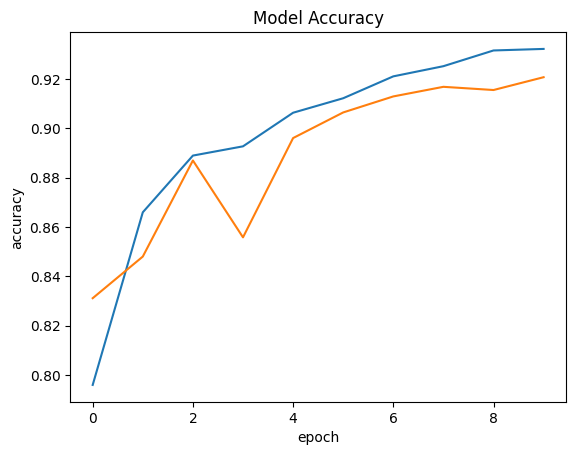

In [ ]:
plt.plot(history.history["binary_accuracy"])
plt.plot(history.history["val_binary_accuracy"])
plt.title("Model Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()

## Evaluate results on the test set

In [ ]:
model.load_weights('/kaggle/working/val-best.h5')
model.evaluate(testGen)

770/770 [==============================] - 8s 11ms/step - loss: 0.2533 - binary_accuracy: 0.8896 - auc: 0.9613 - precision: 0.8713 - recall: 0.9143


[0.25333598256111145,
 0.8896104097366333,
 0.9613391160964966,
 0.8712871074676514,
 0.9142857193946838]